In [1]:
!cp /content/drive/MyDrive/pretrained_model/StyleGAN2.zip /content
!unzip /content/StyleGAN2.zip

Archive:  /content/StyleGAN2.zip
   creating: content/StyleGAN2/
  inflating: content/StyleGAN2/LICENSE  
  inflating: content/StyleGAN2/model.py  
   creating: content/StyleGAN2/models/
   creating: content/StyleGAN2/__pycache__/
   creating: content/StyleGAN2/stylegan/
  inflating: content/StyleGAN2/models/pggan_generator.py  
  inflating: content/StyleGAN2/models/ReadMe.md  
  inflating: content/StyleGAN2/models/stylegan2_discriminator.py  
  inflating: content/StyleGAN2/models/pggan_discriminator.py  
   creating: content/StyleGAN2/models/__pycache__/
  inflating: content/StyleGAN2/models/__pycache__/stylegan2_generator.cpython-37.pyc  
  inflating: content/StyleGAN2/models/stylegan2_generator.py  
  inflating: content/StyleGAN2/models/model_zoo.py  
  inflating: content/StyleGAN2/__pycache__/model.cpython-37.pyc  
  inflating: content/StyleGAN2/stylegan/stylegan2_church256.pth  
  inflating: content/StyleGAN2/stylegan/stylegan2_cat256.pth  


In [2]:
!git clone https://github.com/blandocs/improved-precision-and-recall-metric-pytorch

Cloning into 'improved-precision-and-recall-metric-pytorch'...
remote: Enumerating objects: 437, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 437 (delta 20), reused 17 (delta 17), pack-reused 413
Receiving objects: 100% (437/437), 576.17 MiB | 35.75 MiB/s, done.
Resolving deltas: 100% (21/21), done.
Checking out files: 100% (390/390), done.


In [3]:
!pip install gputil -q

In [4]:
%%writefile usage.py
import GPUtil
from threading import Thread
import time

class Monitor(Thread):
    def __init__(self, delay):
        super(Monitor, self).__init__()
        self.stopped = False
        self.delay = delay # Time between calls to GPUtil
        self.start()

    def run(self):
        while not self.stopped:
            GPUtil.showUtilization()
            time.sleep(self.delay)

    def stop(self):
        self.stopped = True
        
monitor = Monitor(10)

Writing usage.py


In [2]:
import os, sys

sys.path.append('/content/content/StyleGAN2')
from model import pggan, stylegan2
from tqdm import tqdm

import torch
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

print('load model...')
# model_path = '/content/content/StyleGAN2/stylegan/stylegan2_cat256.pth'
model_path = '/content/content/StyleGAN2/stylegan/stylegan2_church256.pth'
G, D = stylegan2(path=model_path, res=256)
G.to(device)
D.to(device)
print('models completes')

load model...
models completes


In [1]:
def g_nonsaturating_loss(fake_pred):
    loss = F.softplus(-fake_pred).mean()
    return loss

In [3]:
out = []


for x in tqdm(range(10000)):
    G.eval()
    D.eval()
    z = torch.randn(4, 512, device=device)
    dic = G.mapping(z)
    const = dic['z']
    wp = dic['w']


    grad_X = wp.detach()
    grad_X.requires_grad = True

    fake_img = G(grad_X)
    fake_pred = D(fake_img['image'])
    g_loss = g_nonsaturating_loss(fake_pred)
    g_loss.backward()

    grad = grad_X.grad.data

    img = fake_img['image'].permute(0,2,3,1).detach().cpu().numpy()
    img = (img+1) * 127.5
    img = img.astype(int)
    np_grad = grad.cpu().numpy()
    np_w = wp.detach().cpu().numpy()
    grads = np.std(np_grad,axis=1)
    for (w, gr,im) in zip(np_w,grads,img):
        out.append((w,gr))        

100%|██████████| 10000/10000 [1:31:01<00:00,  1.83it/s]


In [ ]:
df = pd.DataFrame(df)
df.to_csv('/content/drive/MyDrive/pretrained_model/stylegan/cat_40000.csv',index=False)
df = pd.read_csv('/content/drive/MyDrive/pretrained_model/stylegan/cat_40000.csv')

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


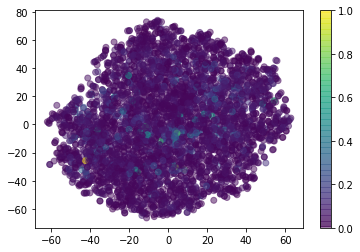

In [20]:
from sklearn.manifold import TSNE
zs = []
vogs = []
for z,vog,_ in out:
    zs.append(z)
    vogs.append(vog)

def get_tsne(noise, vog_score):
    vog_score = (vog_score - np.min(vog_score))/\
                (np.max(vog_score)- np.min(vog_score))
    n_components = 2
    model = TSNE(n_components=n_components)
    if n_components == 3:
        fig = plt.figure(figsize = (10, 7))
        ax = plt.axes(projection ="3d")
        x = (model.fit_transform(noise))
        ax.scatter(x[:,0],x[:,1],x[:,2],c=vog_score,alpha=0.5)
        # plt.colorbar()
    else:
        x = (model.fit_transform(noise))
        # plt.figure(figsize = (10, 7))
        plt.scatter(x[:,0],x[:,1],c=vog_score,alpha=0.5)
        plt.colorbar()
get_tsne(zs,vogs)

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

reg = LinearRegression().fit(zs, vogs)
mlp = MLPRegressor().fit(zs,vogs)

In [26]:
print(reg.score(zs,vogs))
print(mlp.score(zs,vogs))

0.3141218613195308
0.8091760569099262


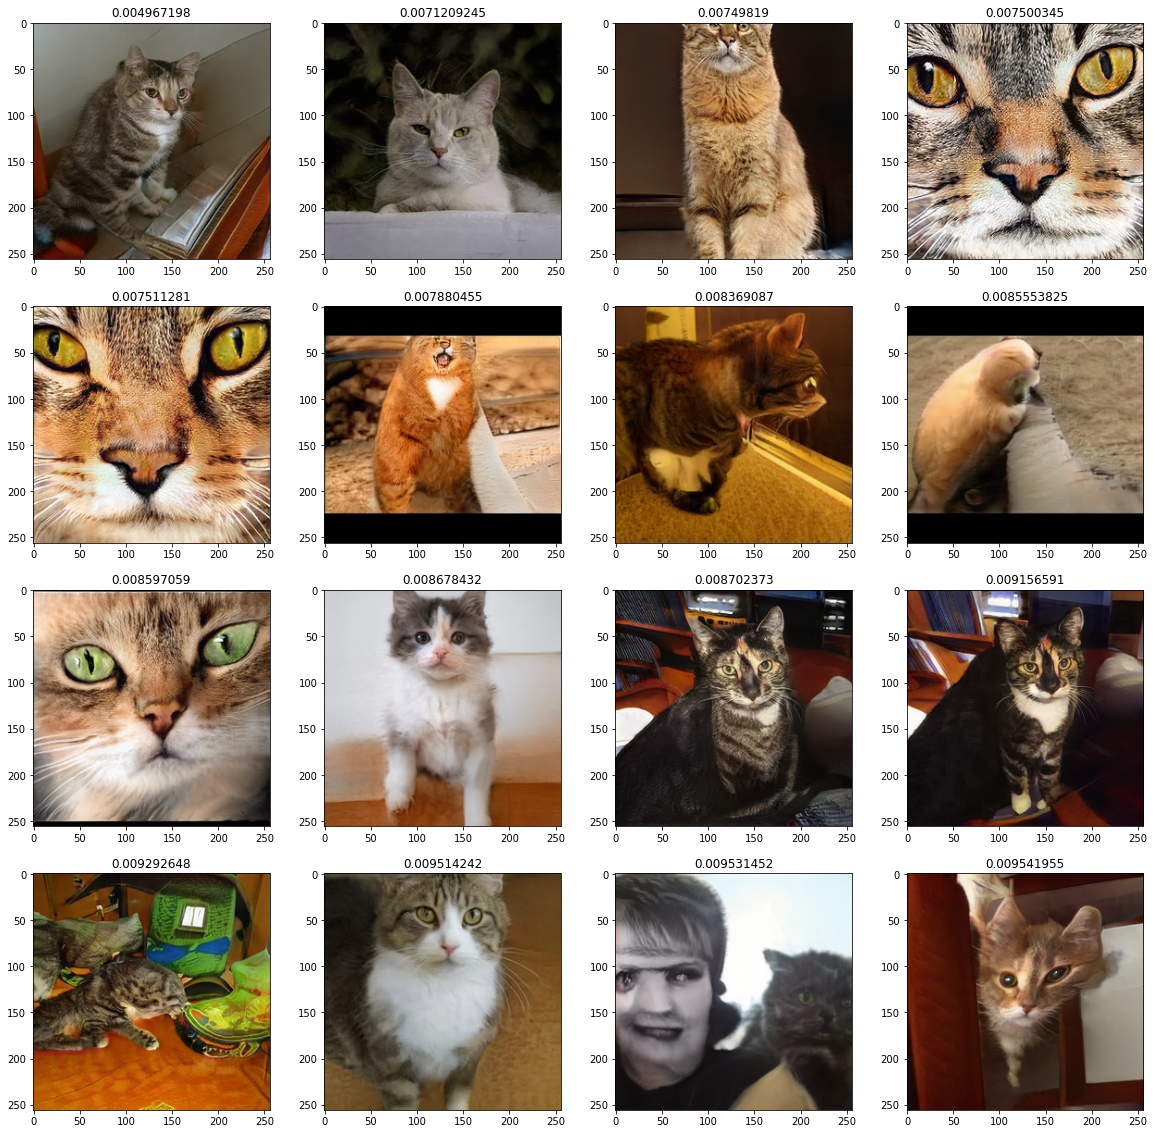

In [21]:
sort_out =  sorted(out, key=lambda x:x[1])
row = 4
col = 4
plt.figure(figsize=(20,20))
idx = 1
for z,g,img in sort_out[:16]:
    plt.subplot(row,col,idx)
    plt.title(g)
    plt.imshow(img)
    idx +=1

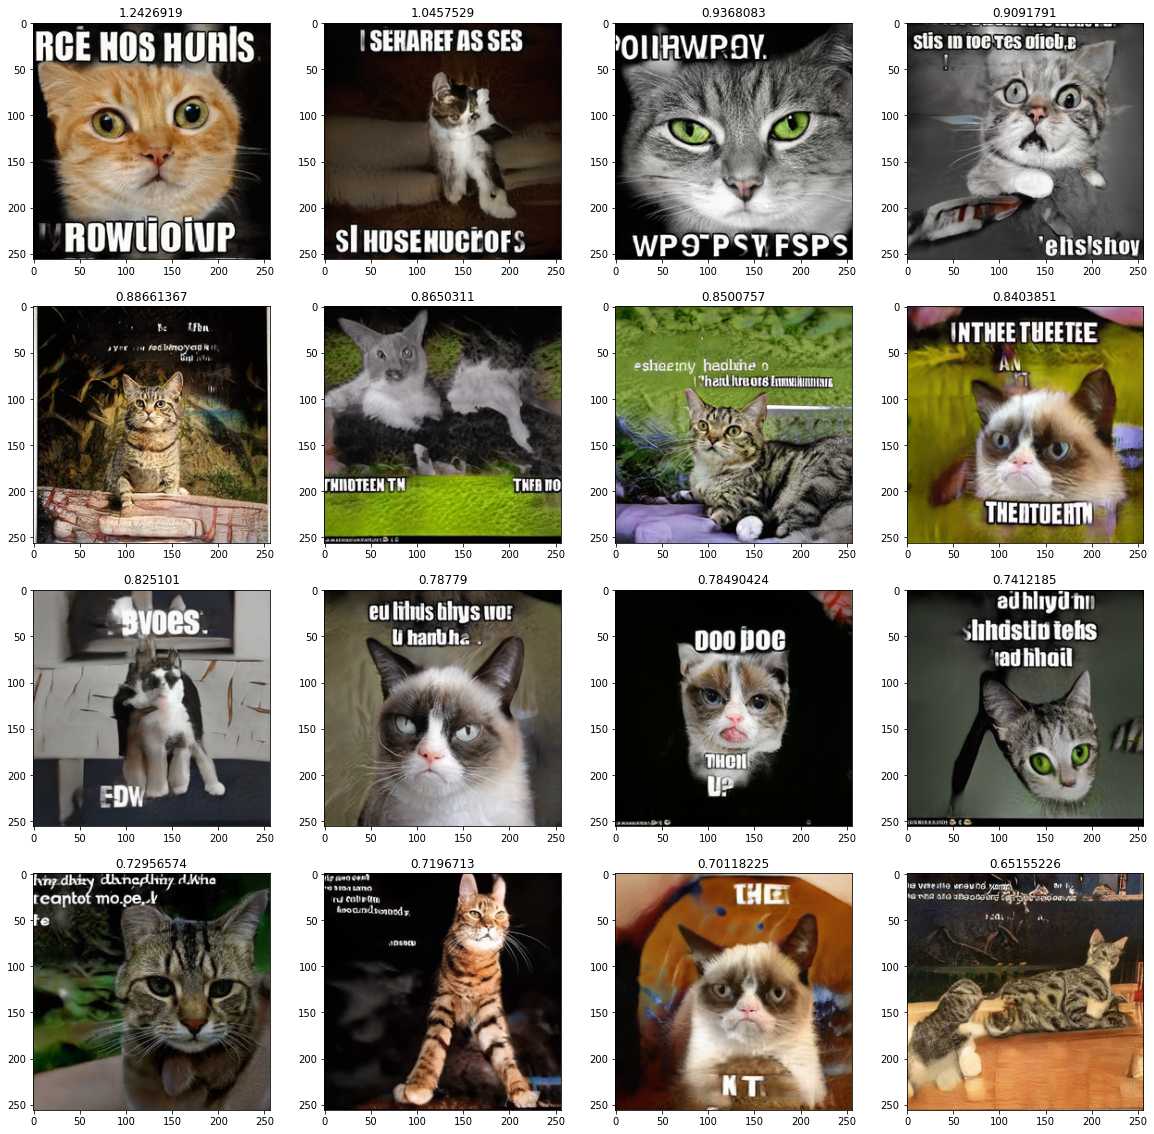

In [22]:
sort_out =  sorted(out, key=lambda x:x[1], reverse=True)
row = 4
col = 4
plt.figure(figsize=(20,20))
idx = 1
for z,g,img in sort_out[:16]:
    plt.subplot(row,col,idx)
    plt.title(g)
    plt.imshow(img)
    idx +=1


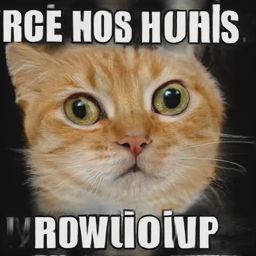

In [35]:
from PIL import Image
t = sort_out[0][-1]
Image.fromarray(((t-t.min())/(t.max()-t.min())*255).astype(np.uint8), 'RGB')

In [42]:
!mkdir /content/data

In [33]:
import pandas as pd
import os
from tqdm import tqdm

sort_out =  sorted(out, key=lambda x:x[1], reverse=True)

out_path = '/content/data'
df = []
img_id = 0
for z,g in sort_out:
    t = i
    img = Image.fromarray(((t-t.min())/(t.max()-t.min())*255).astype(np.uint8), 'RGB')
    img_path = os.path.join(out_path,str(img_id)+'.png')
    img.save(img_path)
    dic = {'id':img_id,
           'img_path':img_path,
           'vog_score':g,
           'z': z}
    img_id+=1
    df.append(dic)

  0%|          | 0/40000 [00:00<?, ?it/s]


NameError: ignored

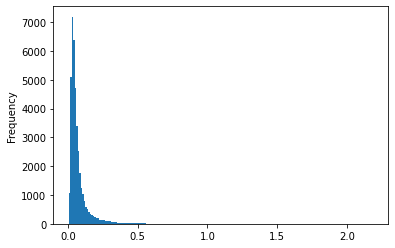

In [42]:
df['vog_score'].plot(kind='hist',bins=200)

In [65]:
import easydict
args = easydict.EasyDict({
    'result_dir' :'/content/data',
    'generated_dir' : '/content/data',
    'real_dir' : None,
    'batch_size' : 16,
    'cpu' : 2,
    'data_size' :
})

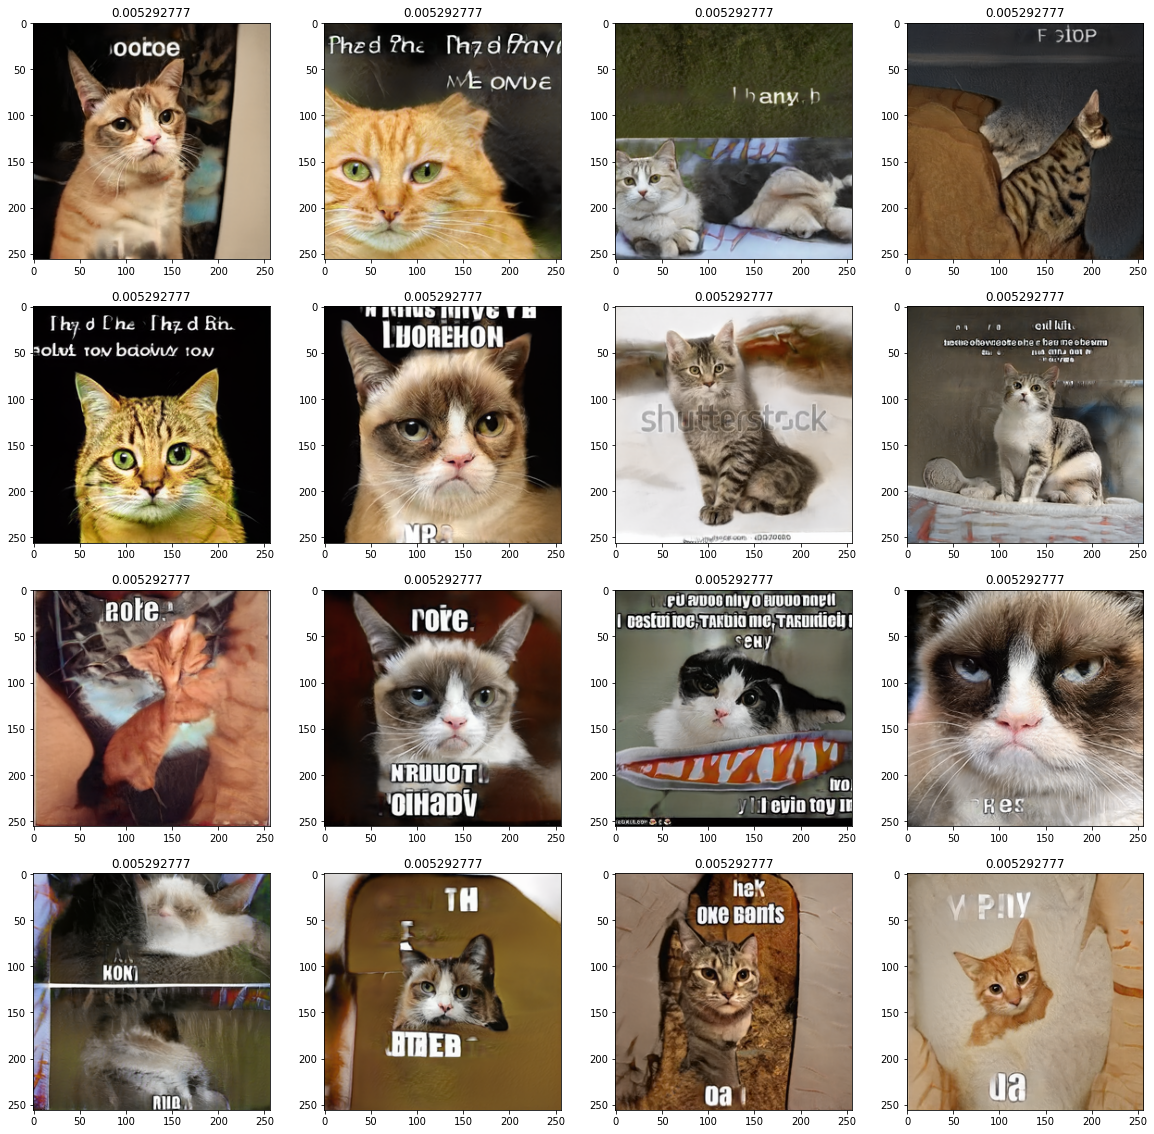

In [31]:
h = np.asarray(list(df['z'][:16]))
h = torch.Tensor(h).to(device)
o = G(h)
i = o['image']
i = i.permute(0,2,3,1).detach().cpu().numpy()
i = ((i+1)*127.5).astype(int)
row = 4
col = 4
plt.figure(figsize=(20,20))
idx = 1
for img in i:
    plt.subplot(row,col,idx)
    plt.title(g)
    plt.imshow(img)
    idx +=1

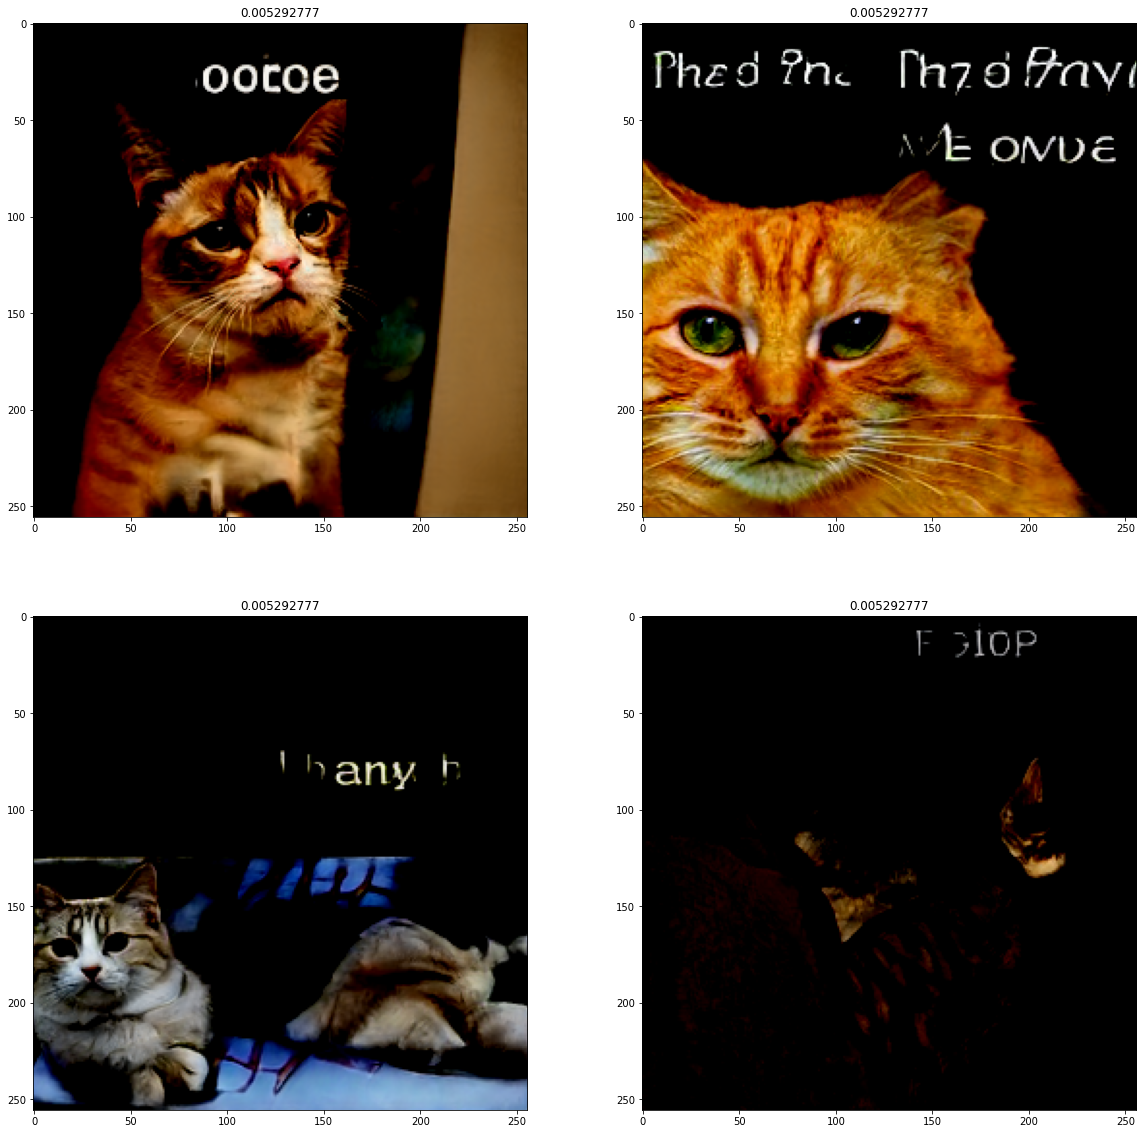

In [71]:
from functions import realism
task = realism(args)
out = task.run()

100%|█████████████████████████████████████████| 250/250 [00:30<00:00,  8.17it/s]


TypeError: ignored